In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipy_table as tbl
from numbers import Number
from scipy import stats
#allow plots and visualisations to be displayed 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['table', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [76]:
titanic_data=pd.read_csv('titanic_train.csv')

In [77]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [78]:
#makeing functions that will be used later
def as_percent(val, precision='0.2'):
    """Convert number to percentage string."""
    if isinstance(val, Number):
        return "{{:{}%}}".format(precision).format(val)
    else:
        raise TypeError("Numeric type required")

def calculate_percentage(val, total, format_percent = False):
    """Calculates the percentage of a value over a total"""
    percent = np.divide(val, total, dtype=float)
    if format_percent:
        percent = as_percent(percent)
    return percent

## from the info we see that Age, cabin and Embarked

In [79]:
missing_ages = titanic_data[titanic_data['Age'].isnull()]
# determine mean age based on Sex and Pclass
mean_ages = titanic_data.groupby(['Sex','Pclass'])['Age'].mean()

def remove_na_ages(row):
    '''
    function to check if the age is null and replace wth the mean from 
    the mean ages dataframe 
    '''
    if pd.isnull(row['Age']):
        return mean_ages[row['Sex'],row['Pclass']]
    else:
        return row['Age']

titanic_data['Age'] =titanic_data.apply(remove_na_ages, axis=1)

In [80]:
missing_ports=titanic_data[titanic_data['Embarked'].isnull()]
missing_ports

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [81]:
# search by ticket number and cabin
titanic_data[(titanic_data['Embarked'].notnull()) & ((titanic_data['Ticket'] == '113572') | (titanic_data['Cabin'] == 'B28'))]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked



Since searching for similar records did not return any results and it appears that both were travelling in the same cabin and with the same ticket number and the bulk of passengers were travelling from Southhampton, I have choosen to use Southhampton as the missing value.

In [82]:
titanic_data['Embarked'].fillna('S',inplace=True)

##### cabin,name and ticket are not required as they are unique so won't help in the analysis, so they are removed

In [83]:
titanic_data=titanic_data.drop(['Cabin','Name','Ticket'], axis=1)
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.7+ KB


### In order to intrepret the data easier the following fields need to be modified:

Survived - changed to boolean (1 = True, 0 = False)
Pclass - changed to Socio-Economic status (1st - Upper Class, 2nd - Middle Class, 3rd - Lower Class)
Embarked - changed to name of embarkation port (C = Cherbourg; Q = Queenstown; S = Southampton)
I will also add a Family Size column so that I can compare the size of families with the number of survivors.

In [84]:
def map_data(df):
    #mapping function to make data more readable
    
    #survuved map
    survived_map = {0: False, 1: True}
    df['Survived'] = df['Survived'].map(survived_map)
    
    #Pclass map
    pclass_map={1: 'Upper Class',2: 'Middle Class',3: 'Lower Class'}
    df['Pclass'] = df['Pclass'].map(pclass_map)
    
    # Embarkation map
    port_map = {'S': 'Southhampton','C': 'Cherbourg','Q': 'Queenstown'}
    df['Embarked'] = df['Embarked'].map(port_map)
    
    #add new family size column
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
    return df

In [85]:
titanic_data=map_data(titanic_data)

In [86]:
titanic_data.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,1,False,Lower Class,male,22.0,1,0,7.2500,Southhampton,1
1,2,True,Upper Class,female,38.0,1,0,71.2833,Cherbourg,1
2,3,True,Lower Class,female,26.0,0,0,7.9250,Southhampton,0


## grouping ages to analysis better

In [87]:
age_labels = ['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-79']

titanic_data['age_group']= pd.cut(titanic_data.Age, range(0,81,10),right=False,labels=age_labels)

In [88]:
titanic_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,age_group
0,1,False,Lower Class,male,22.000000,1,0,7.2500,Southhampton,1,20-29
1,2,True,Upper Class,female,38.000000,1,0,71.2833,Cherbourg,1,30-39
2,3,True,Lower Class,female,26.000000,0,0,7.9250,Southhampton,0,20-29
3,4,True,Upper Class,female,35.000000,1,0,53.1000,Southhampton,1,30-39
4,5,False,Lower Class,male,35.000000,0,0,8.0500,Southhampton,0,30-39
5,6,False,Lower Class,male,26.507589,0,0,8.4583,Queenstown,0,20-29
6,7,False,Upper Class,male,54.000000,0,0,51.8625,Southhampton,0,50-59
7,8,False,Lower Class,male,2.000000,3,1,21.0750,Southhampton,4,0-9
8,9,True,Lower Class,female,27.000000,0,2,11.1333,Southhampton,2,20-29
9,10,True,Middle Class,female,14.000000,1,0,30.0708,Cherbourg,1,10-19


## proportion of survuvors by Gender

In [89]:
table = pd.crosstab(titanic_data['Survived'],titanic_data['Sex'])
print(table)

Sex       female  male
Survived              
False         81   468
True         233   109


## proportion of survivors by Gender

In [90]:
print(titanic_data.groupby('Sex').Survived.mean())

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


In [100]:
survivior_data = titanic_data[titanic_data.Survived == True]
non_survivor_data = titanic_data[titanic_data.Survived == False]

In [92]:
#calculate values for each srvival status
survivor_gender = survivior_data.groupby(['Sex']).size().values
non_survivor_gender = non_survivor_data.groupby(['Sex']).size().values

In [93]:
total = survivor_gender + non_survivor_gender

In [94]:
data1_percentages = calculate_percentage(survivor_gender, total)*100 
data2_percentages = calculate_percentage(non_survivor_gender, total)*100 

gender_categories = ['Female', 'Male']

Text(0.5,1,'% of survivors by gender')

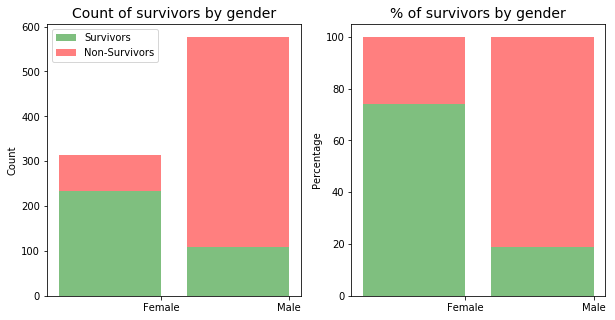

In [95]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# plot chart for count of survivors by class
ax1.bar(range(len(survivor_gender)), survivor_gender, label='Survivors', alpha=0.5, color='g')
ax1.bar(range(len(non_survivor_gender)), non_survivor_gender, bottom=survivor_gender, label='Non-Survivors', alpha=0.5, color='r')
plt.sca(ax1)
plt.xticks([0.4, 1.4], gender_categories )
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Count of survivors by gender",fontsize=14)
plt.legend(loc='upper left')


# plot chart for percentage of survivors by class
ax2.bar(range(len(data1_percentages)), data1_percentages, alpha=0.5, color='g')
ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, alpha=0.5, color='r')
plt.sca(ax2)
plt.xticks([0.4, 1.4],  gender_categories)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("% of survivors by gender",fontsize=14)

The plots and proportions above show that there were a significant more males on board the Titanic compared to the number of females. Whilst the second plot (% of survivors by gender) shows that Females had a higher proportion (74.2%) of survivors compared to the proportion of males (18.9%). This shows that females had a greater rate of survival.

As the P-Value is less than 0.05 the probability of that the age group will impact the chances of survival is high. Therefore I believe that we can reject the null hypothesis.

In [96]:
table = pd.crosstab([titanic_data['Survived']], titanic_data['Sex'])
chi2, p, dof, expected = stats.chi2_contingency(table.values)
results = [
    ['Item','Value'],
    ['Chi-Square Test',chi2],
    ['P-Value', p]
]
tbl.make_table(results)

Item,Value
Chi-Square Test,260.7170
P-Value,0.0000



As the P-Value is less than 0.05 the probability of that the gender will impact the chances of survival is high. Therefore I believe that we can reject the null hypothesis. I also believe that the plots above confirm this result.

In [97]:
table = pd.crosstab(titanic_data['Survived'],titanic_data['Pclass'])
print(table)

Pclass    Lower Class  Middle Class  Upper Class
Survived                                        
False             372            97           80
True              119            87          136


In [98]:
print(titanic_data.groupby('Pclass').Survived.mean())

Pclass
Lower Class     0.242363
Middle Class    0.472826
Upper Class     0.629630
Name: Survived, dtype: float64


In [101]:
# calculate values for each survival status
survivors_class = survivior_data.groupby(['Pclass']).size().values
non_survivors_class = non_survivor_data.groupby(['Pclass']).size().values

# calculate totals for percentates
totals = survivors_class + non_survivors_class

# use calculate_percentage_function to calculate percentage of the total
data1_percentages = calculate_percentage(survivors_class, totals)*100 
data2_percentages = calculate_percentage(non_survivors_class, totals)*100 


class_categories = ['Lower Class', 'Middle Class', 'Upper Class']


Text(0.5,1,'% of survivors by class')

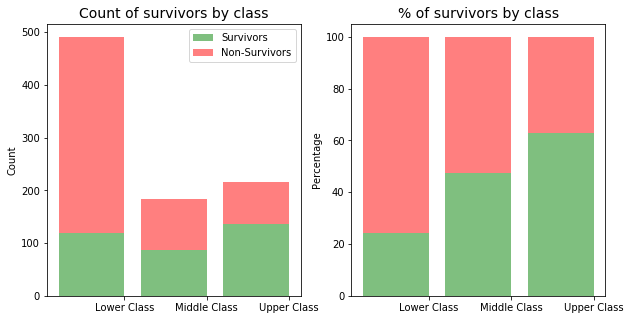

In [102]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# plot chart for count of survivors by class
ax1.bar(range(len(survivors_class)), survivors_class, label='Survivors', alpha=0.5, color='g')
ax1.bar(range(len(non_survivors_class)), non_survivors_class, bottom=survivors_class, label='Non-Survivors', alpha=0.5, color='r')
plt.sca(ax1)
plt.xticks([0.4, 1.4, 2.4], class_categories )
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Count of survivors by class",fontsize=14)
plt.legend(loc='upper right')

# plot chart for percentage of survivors by class
ax2.bar(range(len(data1_percentages)), data1_percentages, alpha=0.5, color='g')
ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, alpha=0.5, color='r')
plt.sca(ax2)
plt.xticks([0.4, 1.4, 2.4],  class_categories)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("% of survivors by class",fontsize=14)

The graphs above so that whilst the lower class had more passengers, than all classes, and more survivors than the middle class, the lower class had the lowest survival rate. The Upper Class passengers had the highest survival rate

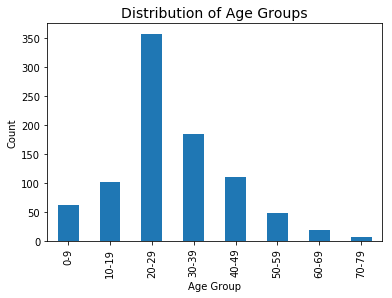

In [104]:
titanic_data.groupby(['age_group']).size().plot(kind='bar',stacked=True)
plt.title("Distribution of Age Groups",fontsize=14)
plt.ylabel('Count')
plt.xlabel('Age Group');

In [105]:
print(titanic_data.groupby(['age_group']).Survived.mean())

age_group
0-9      0.612903
10-19    0.401961
20-29    0.315642
30-39    0.454054
40-49    0.354545
50-59    0.416667
60-69    0.315789
70-79    0.000000
Name: Survived, dtype: float64


In [109]:
# calculate values for each survival status
survivors_age_group = survivior_data.groupby(['age_group']).size().values
non_survivors_age_group = non_survivor_data.groupby(['age_group']).size().values

# calculate totals for percentates
totals = survivors_age_group + non_survivors_age_group

# use calculate_percentage_function to calculate percentage of the total
data1_percentages = calculate_percentage(survivors_age_group, totals)*100 
data2_percentages = calculate_percentage(non_survivors_age_group, totals)*100 


tick_spacing = np.array(range(len(age_labels)))+0.4


Text(0.5,1,'% of survivors by age group')

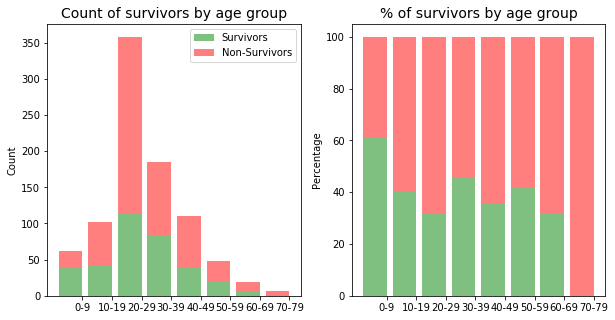

In [110]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# plot chart for count of survivors by class
ax1.bar(range(len(survivors_age_group)), survivors_age_group, label='Survivors', alpha=0.5, color='g')
ax1.bar(range(len(non_survivors_age_group)), non_survivors_age_group, bottom=survivors_age_group, label='Non-Survivors', alpha=0.5, color='r')
plt.sca(ax1)
plt.xticks(tick_spacing, age_labels )
ax1.set_ylabel("Count")
ax1.set_xlabel("")
ax1.set_title("Count of survivors by age group",fontsize=14)
plt.legend(loc='upper right')

# plot chart for percentage of survivors by class
ax2.bar(range(len(data1_percentages)), data1_percentages, alpha=0.5, color='g')
ax2.bar(range(len(data2_percentages)), data2_percentages, bottom=data1_percentages, alpha=0.5, color='r')
plt.sca(ax2)
plt.xticks(tick_spacing,  age_labels)
ax2.set_ylabel("Percentage")
ax2.set_xlabel("")
ax2.set_title("% of survivors by age group",fontsize=14)

In [111]:
print(titanic_data.groupby(['Sex','age_group']).Survived.mean())

Sex     age_group
female  0-9          0.633333
        10-19        0.755556
        20-29        0.681034
        30-39        0.855072
        40-49        0.687500
        50-59        0.888889
        60-69        1.000000
male    0-9          0.593750
        10-19        0.122807
        20-29        0.140496
        30-39        0.215517
        40-49        0.217949
        50-59        0.133333
        60-69        0.133333
        70-79        0.000000
Name: Survived, dtype: float64


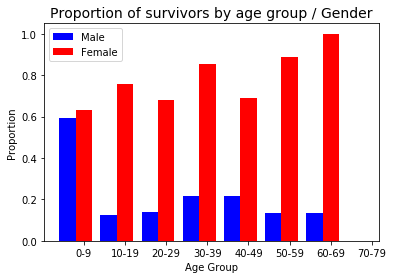

In [113]:
male_data = titanic_data[titanic_data.Sex == "male"].groupby('age_group').Survived.mean().values
female_data = titanic_data[titanic_data.Sex == "female"].groupby('age_group').Survived.mean().values
ax = plt.subplot()
male_plt_position = np.array(range(len(age_labels)))
female_plt_position = np.array(range(len(age_labels)))+0.4
ax.bar(male_plt_position, male_data,width=0.4,label='Male',color='b')
ax.bar(female_plt_position, female_data,width=0.4,label='Female',color='r')
plt.xticks(tick_spacing,  age_labels)
ax.set_ylabel("Proportion")
ax.set_xlabel("Age Group")
ax.set_title("Proportion of survivors by age group / Gender",fontsize=14)
plt.legend(loc='best')
plt.show()


After relooking at the proportion of survivors by age group and gender, the data supports notion of women and children to be given preferential treatment over men. The plot "Proportion of survivors by age group / gender", shows that children (0-9 years old, male and female) and women (all ages) had a much higher proportion of survivors. This supports the notion of the seats in the lifeboats been given to Women and Children first.